# PA 1 - A* Pathfinding

**Name:** [Your Name]
**Roll Number:** [Your Roll Number]

---

### Instructions

In this assignment, you will implement the **A\* search algorithm** to find the shortest walking path between the **Syed Babar Ali School of Science and Engineering (SSE)** and the **Suleman Dawood School of Business (SDSB)** using a real-world map of the LUMS campus.

You will be working with a graph where:
- **Nodes** are intersections or points on a path.
- **Edges** are the walkable paths, with real-world distances as their cost.

Your task is to implement the A\* algorithm and its heuristic function to find the optimal path.

In [1]:
# # Install and import all necessary libraries
# !pip install osmnx networkx
# %matplotlib inline

import osmnx as ox
import networkx as nx
import heapq
import math
import heapq
import matplotlib.pyplot as plt
from collections import deque

### Step 1: Download and Visualize the Campus Map

First, we will download the walkable network for the LUMS campus polygon from OpenStreetMap.

Map data downloaded successfully


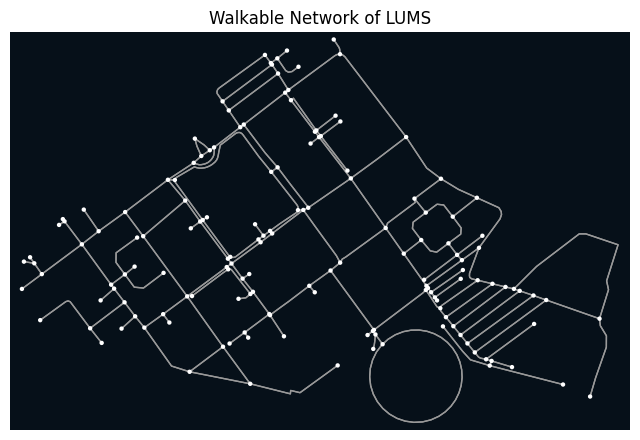

In [2]:
# Define the area of interest
place_name = "Lahore University of Management Sciences, Lahore, Pakistan"

# Download the street network for the area
print(f"Downloading the walkable network for '{place_name}'...")
graph = ox.graph_from_place(place_name, network_type='walk')
print("Map data downloaded successfully")


# Plot the street network to see what we're working with
fig, ax = ox.plot_graph(graph, node_size=10, edge_linewidth=1, show=False, close=False, bgcolor='#061019')
ax.set_title("Walkable Network of LUMS")
plt.show()

### Step 2: Implement the Heuristic Function

A* search requires a heuristic function, $h(n)$. For our map, we will implement the **Haversine formula** to calculate the straight-line distance between two points on a sphere (the Earth). This is an *admissible* heuristic because it never overestimates the true road distance.

**Your task is to translate this formula into Python code.**

**Variables:**
- $\phi$: Latitude
- $\lambda$: Longitude
- $r$: Earth's radius (6,371,000 meters)

**Formula Steps:**
1.  Calculate $a = \sin^2\left(\frac{\Delta\phi}{2}\right) + \cos(\phi_1) \cos(\phi_2) \sin^2\left(\frac{\Delta\lambda}{2}\right)$
2.  Calculate $c = 2 \cdot \text{atan2}\left(\sqrt{a}, \sqrt{1-a}\right)$
3.  Calculate distance $d = r \cdot c$

**Important:** Python's math functions (`math.sin`, `math.cos`) work with **radians**. You must convert the latitude and longitude values from degrees to radians first using `math.radians()`.

In [3]:

import math
def heuristic(node1_coords, node2_coords):
    """
    Calculates the Haversine distance between two nodes.
    """
    # --- TODO: IMPLEMENT THE HEURISTIC CALCULATION ---
    node_1_rad = (math.radians(node1_coords['y']), math.radians(node1_coords['x']))
    node_2_rad = (math.radians(node2_coords['y']), math.radians(node2_coords['x']))

    delta_lat = ((node_1_rad[0]) - node_2_rad[0])/2
    delta_long = ((node_1_rad[1] - node_2_rad[1]))/2

    sin_2_lat = math.sin(delta_lat)**2
    sin_2_long = math.sin(delta_long)**2

    a = sin_2_lat + math.cos(node_1_rad[0]) * math.cos(node_2_rad[0]) * sin_2_long

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    R = 6371000
    return R * c

In [11]:
def strace_back_path_to_goal(goal_node, path_to_goal):
    path = []
    node = goal_node
    while node is not None:
        path.append(node)
        node = path_to_goal[node]
    path.reverse()
    return path



### Step 3: Implement the A* Search Algorithm

Now, implement the A* algorithm. Your goal is to find the path that minimizes the total estimated cost, $f(n)$, where:

$$f(n) = g(n) + h(n)$$

-   **$g(n)$**: The true road distance from the start to node $n$.
-   **$h(n)$**: Your Haversine heuristic from node $n$ to the goal.

You will use a **priority queue** to always expand the node with the lowest $f(n)$ value.

In [12]:
def a_star_search(graph, start_node, goal_node):
    """
    Finds the shortest path between two nodes using the A* algorithm.
    """
    # --- TODO: IMPLEMENT A* SEARCH ALGORITHM HERE ---
    # Hints:
    # 1. Use a priority queue (heapq).
    # 2. `g_score` stores the cost from the start. Edge cost is the 'length' attribute.

    start_coords = graph.nodes[start_node]
    goal_coords = graph.nodes[goal_node]

    g_scores = {}
    path_to_goal = {}
    priority_queue = []
    
    g_scores[start_node] = 0
    path_to_goal[start_node] = None
    f_of_n = 0 + heuristic(start_coords, goal_coords)

    heapq.heappush(priority_queue, (f_of_n, start_node))
    if start_node == goal_node:
        print("Start is the goal!")

    while True:
        min_cost, parent_node = heapq.heappop(priority_queue) 
        if parent_node == goal_node:
            print("Goal reached!")
            return strace_back_path_to_goal(goal_node, path_to_goal)
        else: 
            for neighbor_node in list(graph.neighbors(parent_node)):
                neighbor_coords = graph.nodes[neighbor_node]
                g_of_n = g_scores[parent_node] +  graph.get_edge_data(parent_node, neighbor_node)[0]['length']

                if neighbor_node in g_scores and g_of_n >= g_scores[neighbor_node]:
                    continue
                
                g_scores[neighbor_node] = g_of_n
                path_to_goal[neighbor_node] = parent_node

                f_of_n = g_of_n + heuristic(neighbor_coords, goal_coords)
                heapq.heappush(priority_queue, (f_of_n, neighbor_node))

        if not priority_queue:
            print("No path to the goal exists.")
            break

### Step 4: Find and Visualize the Route from SDSB to SSE

This final cell will use your functions to find the shortest path and display it on a static map.

In [13]:

# Define the coordinates for the two buildings (DO NOT CHANGE THE VALUES OF THE COORDINATES)
sdsb_location = (31.4687, 74.4095) # Suleman Dawood School of Business
sse_location = (31.4718, 74.4111)  # Syed Babar Ali School of Science and Engineering

# Find the closest nodes in the graph to these coordinates 
sse_node = ox.distance.nearest_nodes(graph, sse_location[1], sse_location[0])
sdsb_node = ox.distance.nearest_nodes(graph, sdsb_location[1], sdsb_location[0])

# --- TODO: CALL YOUR A* SEARCH ALGORITHM HERE ---
path = a_star_search(graph, sse_node, sdsb_node)


Goal reached!



 Number of intersections in path: 12
Total route distance: 479.92 meters


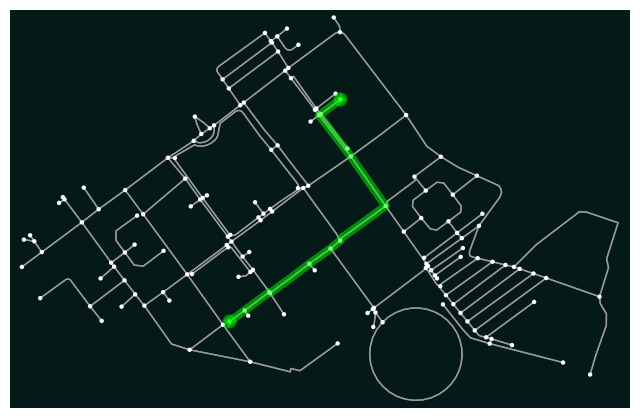

In [14]:
# Visualize the route using a static matplotlib plot (DO NOT CHANGE THIS CELL)
if path:
    print(f"\n Number of intersections in path: {len(path)}")
    total_distance = nx.path_weight(graph, path, weight='length')
    print(f"Total route distance: {total_distance:.2f} meters")

    fig, ax = ox.plot_graph_route(
        graph,
        path,
        route_color='lime',
        route_linewidth=6,
        node_size=10,
        bgcolor='#061919'
    )
    ax.set_title("Shortest Path from SDSB to SSE")

else:
    print("\nNo path found between the specified points.")

### Step 5: Theoretical Analysis

Based on the A* algorithm you just implemented and the results you observed, answer the following questions.

#### Question 1: The Role of the Heuristic

Our A* implementation depends on the Haversine distance heuristic.

a)  What does it mean for a heuristic to be **admissible**? Is our Haversine distance heuristic admissible? Why is this property crucial for A* to find the *shortest* path?

b)  What do you think would happen if our heuristic was **inadmissible** (i.e., it sometimes *overestimated* the distance to the goal)? Would A* still find a path? Would it be guaranteed to be the shortest one?

*Type your answers here...*

a) An admissible heuristic means that the estimated heuristic value will always be less than or equal to the actual path cost, you can say that the heuristic provide optimal possible path cost, in turn making A* an optimal search. i.e h(n) <= h*(n). Therefore the actaul cost of going from node(n) to goal can never be less than h(n) , becuase if there exist a path from node(n) to goal with less cost than h(n) then we must have missed to explore a path, that would have resulted in optimal search.

b) If we suppose a heuristic overestimates some paths, let say we have 2 nodes, node(n1) and node(n2) to goal and their estiamted heuristics and path costs are as below:

       h(n1) > h*(n1)  ---- here h*(n1) is the optimal cost to goal
       h(n2) <= h*(n2) ---- here h*(n2) is the optimal cost to goal

      c(n1) == c(n2)   ---- edge cost/length

      in this case A* will select the node (n2) as the optimal path just becasue the:
      
       h(n2) < h(n1)

       making A* selecting a suboptimal path becasue the heuristic value of h(n1) was over estimated. 

       Thus we can conclude that for A* to be optimal we must have admissible heuristics 